# Show graphs of Beacon Populations


In [2]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.dates as dates
import matplotlib.pyplot as plt
import matplotlib.ticker
import datetime
import collections
import pickle
import time

# Some matplotlib features are version dependent.
assert(matplotlib.__version__ >= '2.1.2')
print "Done"

Done


# Global flags

Invoke cell individually or reorder them to change defaults

In [3]:
EndDate = '2018-05-13'
LastNew = '2017-05-13'  # Beacons that start after this date are not included

In [ ]:
# Skip slow/expensive queries
DoQueries=False
# Force queries
DoQueries=True
# Enable interactive figures that pan and zoom
interactive = True
# Enables figures to load inline in the browser and saved (github etc).
interactive = False

In [75]:
# Disable plots for the paper
DoPaper = False
# Enable plots for the paper
DoPaper = True

In [5]:
def setupmatplotlib(force=None):
    global interactive
    if force == 'inline':
        %matplotlib inline
        return
    elif force == 'interactive':
        %matplotlib
        return
    elif force is not None:
        print 'Unknown option, using default'
    if interactive:
        print 'default interactive'
        %matplotlib
        return
    else:
        print 'default inline'
        %matplotlib inline
        return
setupmatplotlib()

default inline


In [10]:
# Depends on: pip install --upgrade google-cloud-bigquery
# TODO:  COnsider automatically inserting #standardSQL
from google.cloud import bigquery

def expand_query(query, **kwargs):
    """expand_query: expans nested {parameter} substitutions.
    Stashes forensic output in globals.
    """
    global DebugQuery # For pasting into BQ, after the fact
    global NumberedQuery # For grocking BQ error line numbers.
    global DefaultArgs # To ignore some 

    # Only allow argument substitution 4 levels deep, because
    # accidental infinite recursion risks crashing the notebook.
    args = DefaultArgs.copy()
    args.update(kwargs)
    query=query.format(**args)
    query=query.format(**args)
    query=query.format(**args)
    query=query.format(**args)
    if '{' in query:
        raise "Unexpanded substitutions"
    
    # Leave crumbs if we need a postmortem
    DebugQuery = query
    NumberedQuery = ""
    for i, l in enumerate(query.split('\n')):
          NumberedQuery += "%3d %s\n"%(i, l)

    return query

def run_query(query, project='mlab-sandbox', otherindex=None, timeindex='partition_date', **kwargs):
    """ run_query
        Accepts nested {parameter} substitutions.
        
        Stashes forensic output in globals.
    """
    global NumberedQuery
    query=expand_query(query,  **kwargs)

    # do the work
    client = bigquery.Client(project=project)
    job = client.query(query)  # All errors are delayed

    # Marshal the results, catching async errors
    try:
        results = collections.defaultdict(list)
        for row in job.result(timeout=300):
            for key in row.keys():
                results[key].append(row.get(key)) 
    except:
        print NumberedQuery
        raise

    if otherindex:
        return pd.DataFrame(results, index=results[timeined])
    if timeindex:
        return pd.DataFrame(results, index=pd.DatetimeIndex(results[timeindex]))
    # set timeindex=None to force a raw DataFrame
    return pd.DataFrame(results)

def write_query_table(query, otable,
                      project='mlab-sandbox', dataset_id='mattmathis',
                      **kwargs):
    """ write_query_table
        Accepts nested {parameter} substitutions.
        
        Stashes forensic output in globals.
    """
    global NumberedQuery
    query=expand_query(query,  **kwargs)

    # do the work
    client = bigquery.Client(project=project)
    job_config = bigquery.QueryJobConfig()
    table_ref = client.dataset(dataset_id).table(otable)
    job_config.destination = table_ref
    job_config.write_disposition = bigquery.WriteDisposition.WRITE_TRUNCATE
    job = client.query(query, location='US', job_config=job_config)

    # Marshal the results, catching async errors
    try:
        res = job.result()  # Get the first row to make sure it starts
        while not job.done():
            print 'tick'
            time.sleep(5)
        assert job.state == 'DONE'
    except:
        print "Query Errored"
        print NumberedQuery
        raise
    print "Query completed"
    return
# Not tested, can read a table with
#    iterator = client.list_rows(
#        table_ref, selected_fields=[bigquery.SchemaField('my_col', 'INT64')]) 
  
if False:
    testQ="""
    SELECT
        count(*) AS CNT
    FROM
        `mattmathis.new_master_annotations`
    """
    print run_query(testQ, timeindex=None)

print "Done"

       CNT
0  1555329
Done


In [13]:
# Query the list of beacons
BeaconQ ="""
SELECT
  {beacon_fields}
FROM
  `mattmathis.new_master_annotations`
WHERE
  clientIP NOT IN (
    '45.56.98.222',
    '64.9.225.99',
    '64.9.225.190' ) # exclude eb, etc
    {beacon_where}
"""
DefaultArgs = {
    'beacon_where':'',
    'beacon_fields':'clientIP'
}

In [20]:
if False:
    all_beacons = run_query(BeaconQ, timeindex=None)
if True:
    all_beacon_data = run_query(BeaconQ, beacon_fields='*', timeindex=None)

In [21]:
print all_beacon_data


                clientIP  dailymax  series_average_download  \
0          104.132.10.94        66               116.656096   
1        197.231.221.211        47                45.966587   
2          103.19.252.82        42                 9.140027   
3          103.19.253.50        55                15.492654   
4         162.195.123.46        42                37.979055   
5        103.245.206.174        44                10.984749   
6         103.228.40.197        70                 7.666022   
7         103.228.40.198        63                 5.289317   
8          103.255.234.2        52                12.739048   
9        162.253.131.178        60                39.757664   
10        162.194.217.46        98                93.846123   
11         79.131.35.128        93               369.111243   
12         185.69.107.21        62                67.579068   
13        103.229.84.126        44                10.058655   
14          103.31.188.2        45                13.51

Done


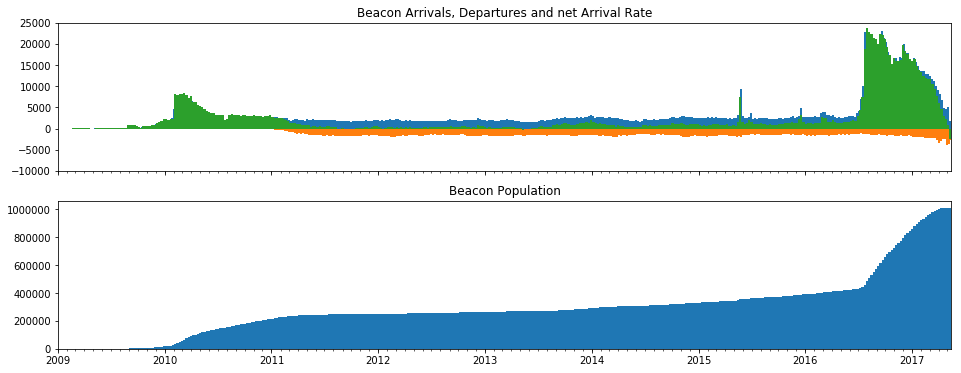

Paper Done


In [78]:
# Non interactive plotting for the paper.
# This version places more attention on the art work
# TODO: set Y limit
def paper_beacon_pop(data, ofile=None, title=None, xlim=None, figsize=(16, 6)):

    fig, axes = plt.subplots(nrows=2, ncols=1, squeeze=False, sharex=True, figsize=figsize)
   
    ax0 = axes[0][0]
    ax1 = ax0
    ax2 = axes[1][0]
    bins = 436  # Weeks between 2009-01-01 and 2017-05-13
    
    ax0.xaxis.set_major_locator(matplotlib.dates.YearLocator())
    ax0.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y'))
    ax0.xaxis.set_minor_locator(matplotlib.dates.MonthLocator())
    ax0.xaxis.set_minor_formatter(matplotlib.dates.DateFormatter(''))
       
    

    starts = dates.epoch2num(data['series_start'])
    ends = dates.epoch2num(data['series_end'])   
    plusOne = [1 for i in range(len(starts))]
    minusOne = [-1 for i in range(len(ends))]
    times = np.append(starts, ends)
    weights = np.append(plusOne,minusOne)

    ax0.set_title('Beacon Arrivals, Departures and net Arrival Rate')
    ax0.hist(starts, cumulative=False, normed=False, bins=bins)
    ax0.hist(ends, weights=minusOne, cumulative=False, normed=False, bins=bins)
    ax0.set_ylim(-10000, 25000)

#    ax1.set_title('Net Arrivals and Departures')
    ax1.hist(times, weights=weights, cumulative=False, bins=bins)
#    ax1.set_ylim(0, 35000)

    ax2.set_title('Beacon Population')
    ax2.hist(times, weights=plusOne+minusOne, cumulative=True, bins=bins)

    #    ax0.legend()
    
    if xlim is not None:
        ax0.set_xlim(xlim)
    if title and not ofile:
        fig.suptitle(title, y='0.97', fontsize=14)
    if ofile:
        fig.savefig(ofile, dpi=100)
    else:
        plt.show()
    plt.close()
print 'Done'
if True:
    paper_beacon_pop(all_beacon_data, xlim=pd.DatetimeIndex(['2009-01-01',LastNew]))

    
if DoPaper:
    paper_beacon_pop(all_beacon_data, ofile='../paper/Beacons.png',figsize=(6,4),
                     xlim=pd.DatetimeIndex(['2009-01-01',LastNew]))
    print 'Paper Done'